In [2]:
from single_cell_class import *
from utils import *
from swim_ephys import *
from kernel_fit import *
from scipy.stats import spearmanr


df = pd.read_csv('../Processing/data_list.csv')
row = df.iloc[15]
save_root = row['save_dir']+'/'

_ = np.load(save_root+'cell_dff.npz', allow_pickle=True)
A = _['A']
A_loc = _['A_loc']
dFF = _['dFF'].astype('float')
_ = None


brain_map = np.load(save_root+'Y_ave.npy').astype('float').squeeze()
A_center = np.load(save_root+'cell_center.npy')
A_center_grid = np.round(A_center).astype('int')
cells_in_mask = []

for n_layer in range(brain_map.shape[0]):
    layer_ = A_center[:, 0]==n_layer
    cell_ids = np.where(layer_)[0]
    mask_ = brain_map[n_layer]>2
    y = A_center_grid[cell_ids, 2]
    x = A_center_grid[cell_ids, 1]
    num_cells = len(cell_ids)
    in_mask_ = np.zeros(num_cells).astype('bool')
    for n in range(num_cells):
        in_mask_[n] = mask_[x[n], y[n]]
    cells_in_mask.append(cell_ids[in_mask_])
cells_in_mask = np.concatenate(cells_in_mask)
A_center = A_center[cells_in_mask]
dFF = dFF[cells_in_mask]

###################################
## Sensory cells
###################################

dat_dir = row['dat_dir'].replace('/im/', '/')
p_dir = dat_dir + 'processed/'
trial_vars = pd.read_pickle(p_dir+'statemod_expt_trialvars.pkl')
behavior = pd.read_pickle(p_dir+'statemod_expt_behavior.pkl')
statemod = pd.read_pickle(p_dir+'statemod-input-vars.pkl')
ephys_dir = dat_dir + 'ephys/'
ephys_dat = glob(ephys_dir+'/*.10chFlt')[0]
fileContent_ = load(ephys_dat)
l_power = windowed_variance(fileContent_[0])[0]
r_power = windowed_variance(fileContent_[1])[0]
camtrig = fileContent_[2]

indx = ep2frame(camtrig, thres=3.8)
frame_ = np.zeros(len(camtrig))
frame_[indx]=1
frame_ = frame_.cumsum()

slide_win = 180000
r_power_baseline = rolling_perc(r_power, window=slide_win, perc=0.1)
l_power_baseline = rolling_perc(l_power, window=slide_win, perc=0.1)

l_power_ = np.clip(l_power-l_power_baseline, 0, None)*10000
r_power_ = np.clip(r_power-r_power_baseline, 0, None)*10000

frame_len = np.min(np.unique(indx[1:]-indx[:-1]))

epoch_frame = np.median(wrap_data(fileContent_[5], indx, frame_len), axis=0).astype('int')
swim_frame = np.mean(wrap_data(l_power_, indx, frame_len), axis=0)
pulse_frame = np.median(wrap_data(fileContent_[8], indx, frame_len), axis=0).astype('int')
visu_frame = np.mean(wrap_data(fileContent_[3], indx, frame_len), axis=0)
visu_frame_ = visu_frame.copy()
visu_frame_[visu_frame_<0]=0

In [3]:
save_root

'/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20200218/fish01/6dpf_HuC-GC7FF-GFAP-RGECO_LG-NGGU_fish01_exp02_20200218_173933//'

### Pulse condition
* Forward sensory cells : Cell respond to pulse without motor

In [4]:
swim_thres = max(np.percentile(swim_frame, 85), 0.2)

pulse_trial = []
pulse_type = []

nopulse_trial = []
nopulse_type = []

pulse_amp = np.unique(pulse_frame)[1]
pulse_on = np.where((pulse_frame[:-1]==0) & (pulse_frame[1:]==pulse_amp))[0]+1
num_dff = dFF.shape[-1]
pulse_on = pulse_on[pulse_on<num_dff-10]

for n, trial in enumerate(pulse_on):
    swim_ = np.clip(swim_frame[trial-2:trial+5]-swim_thres, 0, np.inf)
    if swim_.sum()==0:
        pulse_trial.append(trial)
        pulse_type.append(epoch_frame[trial]//5)
        
nopulse_on = epoch_frame%5==4
nopulse_on = np.where((~nopulse_on[:-1]) & nopulse_on[1:])[0]+1
nopulse_on = nopulse_on[nopulse_on<num_dff-10]
        
for n, trial in enumerate(nopulse_on):
    swim_ = np.clip(swim_frame[trial+3:trial+10]-swim_thres, 0, np.inf)
    if swim_.sum()==0:
        nopulse_trial.append(trial)
        nopulse_type.append(epoch_frame[trial]//5)

### Motor condition
* Motor cells: Cell respond to swim without visual feedback (OL trials)
* Conditional sensorimotor cells: Cell respond to visual or motor while both are presented
* backward conditional cell — CL condition

In [5]:
swim_thres = max(np.percentile(swim_frame, 85), 0.2)
drop_frame = 100
num_dff = dFF.shape[-1]

swim_trial = []
swim_type = []

noswim_trial = []
noswim_type = []

swim_smooth = smooth(swim_frame, gaussKernel(sigma=1.5))
swim_smooth = swim_smooth>swim_thres
swim_on = np.where((swim_smooth[:-1]==0) & (swim_smooth[1:]==1))[0]+1
swim_off = np.where((swim_smooth[:-1]==1) & (swim_smooth[1:]==0))[0]
swim_on = swim_on[swim_on>drop_frame]
swim_on = swim_on[swim_on<num_dff-10]
swim_off = swim_off[swim_off>drop_frame]
swim_off = swim_off[swim_off<num_dff-10]
if swim_off[0]<swim_on[0]:
    swim_off = swim_off[1:]
if swim_on[-1]>swim_off[-1]:
    swim_on = swim_on[:-1]

if swim_on.shape!=swim_off.shape:
    print('Error in swim matches')

swim_lens = (swim_on[1:] - swim_on[:-1])
swim_lens = np.r_[swim_lens, np.inf]
swim_on = swim_on[swim_lens>=7]
swim_off = swim_off[swim_lens>=7]
swim_len = (swim_on[1:] - swim_on[:-1]).min()
pre_len = 2
    
for n, on_ in enumerate(swim_on):
    epoch = epoch_frame[on_-pre_len:on_+swim_len]
    type_ = np.unique(epoch)
    if (len(type_)==1) and ((type_%5<=1).sum()>0):
        swim_trial.append(on_)
        swim_type.append(type_[0])

off_set = 5
for n, off_ in enumerate(swim_off[:-1]):
    if swim_on[n+1]-off_<(off_set*2+pre_len+swim_len):
        continue
    epoch = epoch_frame[(off_+off_set):(off_+pre_len+swim_len+off_set*2)]
    type_, cout_ = np.unique(epoch, return_counts=True)
    if (cout_>(swim_len+pre_len)).sum()>0:
        type_ = type_[np.argmax(cout_).astype('int')]
        if type_%5>1:
            continue
        on_ = np.where(epoch==type_)[0][0]
        if on_+off_+off_set>num_dff:
            continue
        noswim_type.append(type_)
        noswim_trial.append(on_+off_+off_set)

#### Forward conditional cell — OL condition pulse with motor

In [6]:
swim_thres = max(np.percentile(swim_frame, 85), 0.2)

pulse_trial = []
pulse_type = []

pulse_motor_trial = []
pulse_motor_type = []

nopulse_trial = []
nopulse_type = []

pulse_amp = np.unique(pulse_frame)[1]
pulse_on = np.where((pulse_frame[:-1]==0) & (pulse_frame[1:]==pulse_amp))[0]+1
num_dff = dFF.shape[-1]
pulse_on = pulse_on[pulse_on<num_dff-10]

for n, trial in enumerate(pulse_on):
    swim_ = np.clip(swim_frame[trial-2:trial+5]-swim_thres, 0, np.inf)
    if swim_.sum()==0:
        pulse_trial.append(trial)
        pulse_type.append(epoch_frame[trial]//5)
    else:
        pulse_motor_trial.append(trial)
        pulse_motor_type.append(epoch_frame[trial]//5)

        
nopulse_on = epoch_frame%5==4
nopulse_on = np.where((~nopulse_on[:-1]) & nopulse_on[1:])[0]+1
nopulse_on = nopulse_on[nopulse_on<num_dff-10]
        
for n, trial in enumerate(nopulse_on):
    swim_ = np.clip(swim_frame[trial+3:trial+10]-swim_thres, 0, np.inf)
    if swim_.sum()==0:
        nopulse_trial.append(trial)
        nopulse_type.append(epoch_frame[trial]//5)

In [12]:
len(pulse_trial)

1954

In [11]:
for n, trial in enumerate(pulse_motor_trial):
    print(n, trial)

0 2090
1 2094
2 2098
3 2102
4 2106
5 2126
6 2130
7 2134
8 2138
9 2142
10 2146
11 2150
12 2154
13 2158
14 2162
15 2166
16 2170
17 2174
18 2178
19 2182
20 2186
21 2190
22 2194
23 2365
24 2369
25 4041
26 4045
27 4968
28 4972
29 4976
30 4980
31 4984
32 4988
33 4992
34 4996
35 5000
36 5004
37 5008
38 5012
39 5016
40 5020
41 5024
42 5028
43 5032
44 5036
45 5040
46 5044
47 5048
48 5052
49 5056
50 5060
51 5064
52 5068
53 5072
54 5076
55 7929
56 7933
57 7937
58 7941
59 7945
60 7961
61 7965
62 7969
63 7973
64 7977
65 7981
66 7985
67 7989
68 7993
69 7997
70 8001
71 8005
72 8009
73 8013
74 8017
75 8021
76 8025
77 8029
78 8033
79 8037
80 10617
81 10621
82 10625
83 10629
84 10633
85 10645
86 10649
87 10653
88 10657
89 10661
90 10665
91 10669
92 10673
93 10677
94 10681
95 10685
96 10689
97 11562
98 11566
99 14734
100 14738
101 14742
102 14746
103 14750
104 14754
105 14778
106 14782
107 14786
108 14790
109 14794
110 14826
111 14830
112 14834
113 14838
114 14842
115 14846
116 14850
117 19741
118 19745


In [10]:
cell_comp_pulse_motor_stats = np.zeros((num_cells, 5)).astype('O')
num_cpu = 90    
split_ = np.array_split(np.arange(num_cells), num_cells//num_cpu)
for arr in tqdm(split_):
    cell_comp_pulse_motor_stats[arr] = parallel_to_single(comp_stats, dFF[arr], cond_trial=pulse_trial, comp_trial=pulse_motor_trial, pre=2, post=5)[0]  
np.savez(save_root+'cell_comp_pulse_motor_stats', cell_comp_pulse_motor_stats=cell_comp_pulse_motor_stats)

  0%|          | 0/24 [02:00<?, ?it/s]


ValueError: maximum supported dimension for an ndarray is 32, found 146

### Active vs Passive cells

In [133]:
swim_thres = max(np.percentile(swim_frame, 85), 0.2)

active_pulse_trial = []
passive_pulse_trial = []

active_on = np.where((epoch_frame[1:]==3) & (epoch_frame[:-1]==2))[0]+1
passive_on = np.where((epoch_frame[1:]==8) & (epoch_frame[:-1]==7))[0]+1
post_ = 50
pre_ = 2

for n, trial in enumerate(active_on):
    swim_ = np.clip(swim_frame[trial-pre_:trial+post_]-swim_thres, 0, np.inf)
    if swim_.sum()==0:
        active_pulse_trial.append(trial)
    
for n, trial in enumerate(passive_on):
    swim_ = np.clip(swim_frame[trial-pre_:trial+post_]-swim_thres, 0, np.inf)
    if swim_.sum()==0:
        passive_pulse_trial.append(trial)

In [ ]:
active_motor_trial = []
passive_motor_trial = []


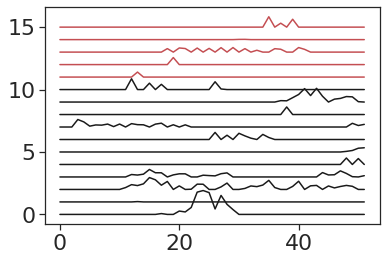

In [130]:
for n, trial in enumerate(active_motor_trial):
    plt.plot(np.clip(swim_frame[trial-pre_:trial+post_]-swim_thres, 0, np.inf)+n, '-k')

for m, trial in enumerate(passive_motor_trial):
    plt.plot(np.clip(swim_frame[trial-pre_:trial+post_]-swim_thres, 0, np.inf)+n+m+1, '-r')    